In [1]:
from scipy.io.wavfile import read, write
import torch
from librosa.util import normalize
from librosa.filters import mel as librosa_mel_fn
import numpy as np
import librosa
from IPython.display import Audio
from tqdm import tqdm, trange
import os
import matplotlib.pyplot as plt
import cv2

In [52]:
MAX_WAV_VALUE = 32768.0

def load_wav(full_path):
    sampling_rate, data = read(full_path)
    return data, sampling_rate

def dynamic_range_compression(x, C=1, clip_val=1e-5):
    return np.log(np.clip(x, a_min=clip_val, a_max=None) * C)

def dynamic_range_decompression(x, C=1):
    return np.exp(x) / C

def dynamic_range_compression_torch(x, C=1, clip_val=1e-5):
    return torch.log(torch.clamp(x, min=clip_val) * C)

def dynamic_range_decompression_torch(x, C=1):
    return torch.exp(x) / C

def spectral_normalize_torch(magnitudes):
    output = dynamic_range_compression_torch(magnitudes)
    return output

def spectral_de_normalize_torch(magnitudes):
    output = dynamic_range_decompression_torch(magnitudes)
    return output

mel_basis = {}
hann_window = {}

def mel_spectrogram(y, n_fft, num_mels, sampling_rate, hop_size, win_size, fmin, fmax, center=False):
    if torch.min(y) < -1.:
        print('min value is ', torch.min(y))
    if torch.max(y) > 1.:
        print('max value is ', torch.max(y))

    global mel_basis, hann_window
    if fmax not in mel_basis:
        mel = librosa_mel_fn(sr=sampling_rate, n_fft=n_fft, n_mels=num_mels, fmin=fmin, fmax=fmax)
        mel_basis[str(fmax)+'_'+str(y.device)] = torch.from_numpy(mel).float().to(y.device)
        hann_window[str(y.device)] = torch.hann_window(win_size).to(y.device)

    y = torch.nn.functional.pad(y.unsqueeze(1), (int((n_fft-hop_size)/2), int((n_fft-hop_size)/2)), mode='reflect')
    y = y.squeeze(1)

    spec = torch.stft(y, n_fft, hop_length=hop_size, win_length=win_size, window=hann_window[str(y.device)],
                      center=center, pad_mode='reflect', normalized=False, onesided=True)

    spec = torch.sqrt(spec.pow(2).sum(-1)+(1e-9))

    spec = torch.matmul(mel_basis[str(fmax)+'_'+str(y.device)], spec)
    spec = spectral_normalize_torch(spec)

    return spec

def show_mel(audio_file, save_name=None, sr=16000):
    ori_wav = librosa.load(audio_file, sr)[0]
    ori_wav = np.clip(ori_wav, -1, 1)
    x = torch.FloatTensor(ori_wav)
    x = mel_spectrogram(x.unsqueeze(0), n_fft=2048, num_mels=80, sampling_rate=16000,
                            hop_size=128, win_size=128, fmin=0, fmax=8000)
    # hide x axis
    plt.xticks([])
    # hide y axis
    plt.yticks([])
    # more clear
    spec = x.cpu().numpy()[0]
    # reverse y
    spec = spec[::-1,:]
    in_mel = spec[:,:]
    # in_mel = spec[:,:624]
    print(in_mel.shape)
    plt.imshow(in_mel)
    # save as pdf
    if save_name is not None:
        plt.savefig(save_name, bbox_inches='tight', pad_inches=0)

def show_melfb(audio_file, save_name=None):
    ori_wav = librosa.load(audio_file, sr=16000)[0]
    ori_wav = np.clip(ori_wav, -1, 1)
    x = torch.FloatTensor(ori_wav)
    x = mel_spectrogram(x.unsqueeze(0), n_fft=2048, num_mels=80, sampling_rate=16000,
                            hop_size=256, win_size=128, fmin=0, fmax=8000)
    # hide x axis
    plt.xticks([])
    # hide y axis
    plt.yticks([])
    # more clear
    spec = x.cpu().numpy()[0]
    # in_mel = spec[:,:]
    in_mel = spec[:,:624]
    plt.imshow(in_mel)
    # save as pdf
    if save_name is not None:
        plt.savefig(save_name, bbox_inches='tight', pad_inches=0)
        
def show_video_frames(video_path, frame_rate=1.0, size=224, save_name=None):
    videos = []
    # for video_path in video_paths:
    # cap = cv2.VideoCapture(video_path)
    cap = cv2.VideoCapture(video_path, cv2.CAP_FFMPEG)
    frameCount = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    if fps < 1:
        images = np.zeros([3, size, size], dtype=np.float32) 
        print("ERROR: problem reading video file: ", video_path)
    else:
        total_duration = (frameCount + fps - 1) // fps
        start_sec, end_sec = 0, total_duration
        interval = fps / frame_rate
        frames_idx = np.floor(np.arange(start_sec*fps, end_sec*fps, interval))
        ret = True 
            
        for i, idx in enumerate(frames_idx):
            cap.set(cv2.CAP_PROP_POS_FRAMES , idx)
            ret, frame = cap.read()    
            if not ret: break
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)             
            videos.append(frame)
            
        cap.release()
        
    # concat all images and show in one figure
    # videos = videos[:10]
    images = np.concatenate(videos, axis=1)
    # print(images.shape)
    plt.imshow(images)
    if save_name is not None:
        plt.savefig(save_name, bbox_inches='tight', pad_inches=0, dpi=900)

/tmp/ipykernel_3407931/2796252854.py:56: FutureWarning: Pass sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  ori_wav = librosa.load(audio_file, sr)[0]


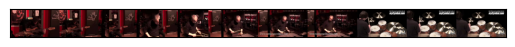

In [37]:
file = "../outputs/tango_video2audio_clip4clip_augment_2/1719298626_tango_video2audio_clip4clip_augment_2_best_steps_300_guidance_3.0_sampleRate_16000_augment/-BAKe6QGTUk_000030_V6-xlXRhkI0_000050_7.wav"
show_mel(file, save_name="1_wav.pdf")
show_video_frames("../data/video_processed/video_gt_augment/-BAKe6QGTUk_000030_V6-xlXRhkI0_000050_7.mp4", save_name="1_video.pdf")

/tmp/ipykernel_3407931/2796252854.py:56: FutureWarning: Pass sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  ori_wav = librosa.load(audio_file, sr)[0]


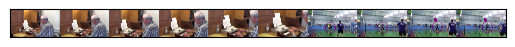

In [38]:
file = "../outputs/tango_video2audio_clip4clip_augment_2/1719298626_tango_video2audio_clip4clip_augment_2_best_steps_300_guidance_3.0_sampleRate_16000_augment/SNanDCQuatA_000189_iAEDIntNw4w_000010_6.wav"
show_mel(file, save_name="2_wav.pdf")
show_video_frames("../data/video_processed/video_gt_augment/SNanDCQuatA_000189_iAEDIntNw4w_000010_6.mp4", save_name="2_video.pdf")

/tmp/ipykernel_3407931/2218442382.py:56: FutureWarning: Pass sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  ori_wav = librosa.load(audio_file, sr)[0]


(720, 12800, 3)


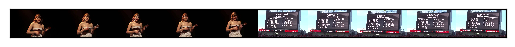

In [30]:
file = "../outputs/tango_video2audio_clip4clip_augment_2/1719298626_tango_video2audio_clip4clip_augment_2_best_steps_300_guidance_3.0_sampleRate_16000_augment/YszbOz38VFE_000020_h_jJj2PbFRI_000009_5.wav"
show_mel(file, save_name="3_wav.pdf")
show_video_frames("../data/video_processed/video_gt_augment/YszbOz38VFE_000020_h_jJj2PbFRI_000009_5.mp4", save_name="3_video.pdf")

/tmp/ipykernel_3407931/2218442382.py:56: FutureWarning: Pass sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  ori_wav = librosa.load(audio_file, sr)[0]


(360, 4800, 3)


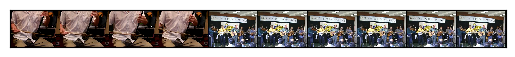

In [28]:
file = "../outputs/tango_video2audio_clip4clip_augment_2/1719298626_tango_video2audio_clip4clip_augment_2_best_steps_300_guidance_3.0_sampleRate_16000_augment/62Sboyh19LA_000182_I7tuwRK0L1w_000220_4.wav"
show_mel(file, save_name="4_wav.pdf")
show_video_frames("../data/video_processed/video_gt_augment/62Sboyh19LA_000182_I7tuwRK0L1w_000220_4.mp4", save_name="4_video.pdf")

/tmp/ipykernel_3407931/2796252854.py:56: FutureWarning: Pass sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  ori_wav = librosa.load(audio_file, sr)[0]


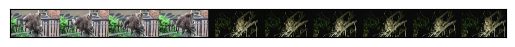

In [44]:
file = "../outputs/tango_video2audio_clip4clip_augment_2/1719298626_tango_video2audio_clip4clip_augment_2_best_steps_300_guidance_3.0_sampleRate_16000_augment/VR1UJLGULOQ_000053_wiyojlC9xbI_000030_4.wav"
show_mel(file, save_name="5_wav.pdf")
show_video_frames("../data/video_processed/video_gt_augment/VR1UJLGULOQ_000053_wiyojlC9xbI_000030_4.mp4", save_name="5_video.pdf")

/tmp/ipykernel_3407931/2796252854.py:56: FutureWarning: Pass sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  ori_wav = librosa.load(audio_file, sr)[0]


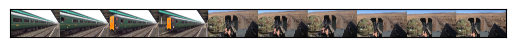

In [45]:
file = "../outputs/tango_video2audio_clip4clip_augment_2/1719298626_tango_video2audio_clip4clip_augment_2_best_steps_300_guidance_3.0_sampleRate_16000_augment/OnYPsGAjYBU_000560_tPnt7aeBK44_000120_4.wav"
show_mel(file, save_name="6_wav.pdf")
show_video_frames("../data/video_processed/video_gt_augment/OnYPsGAjYBU_000560_tPnt7aeBK44_000120_4.mp4", save_name="6_video.pdf")

/tmp/ipykernel_2189924/99652230.py:56: FutureWarning: Pass sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  ori_wav = librosa.load(audio_file, sr)[0]


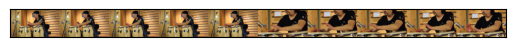

In [3]:
file = "../outputs/tango_video2audio_clip4clip_4/1720425300_tango_video2audio_clip4clip_4_best_steps_300_guidance_3.0_sampleRate_16000_augment/0 (3).wav"
show_mel(file, save_name="ood_0_wav.pdf")
show_video_frames("../data/foleycrafter/0 (3).mp4", save_name="ood_0_video.pdf")

/tmp/ipykernel_2189924/99652230.py:56: FutureWarning: Pass sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  ori_wav = librosa.load(audio_file, sr)[0]


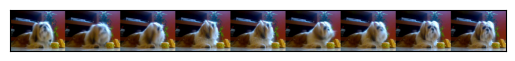

In [6]:
file = "../outputs/tango_video2audio_clip4clip_4/1720425300_tango_video2audio_clip4clip_4_best_steps_300_guidance_3.0_sampleRate_16000_augment/0.wav"
show_mel(file, save_name="ood_1_wav.pdf")
show_video_frames("../data/foleycrafter/0.mp4", save_name="ood_1_video.pdf", frame_rate=2)

/tmp/ipykernel_2189924/978430674.py:56: FutureWarning: Pass sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  ori_wav = librosa.load(audio_file, sr)[0]


(80, 1280)


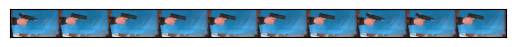

In [53]:
file = "../outputs/tango_video2audio_clip4clip_4/1720425300_tango_video2audio_clip4clip_4_best_steps_300_guidance_3.0_sampleRate_16000_augment/1.wav"
show_mel(file, save_name="ood_2_wav.pdf")
show_video_frames("../data/foleycrafter/1.mp4", save_name="ood_2_video.pdf", frame_rate=1)

/tmp/ipykernel_2189924/99652230.py:56: FutureWarning: Pass sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  ori_wav = librosa.load(audio_file, sr)[0]


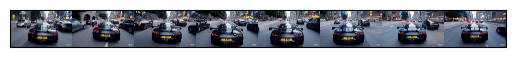

In [12]:
file = "../outputs/tango_video2audio_clip4clip_4/1720425300_tango_video2audio_clip4clip_4_best_steps_300_guidance_3.0_sampleRate_16000_augment/case1.wav"
show_mel(file, save_name="ood_3_wav.pdf")
show_video_frames("../data/foleycrafter/case1.mp4", save_name="ood_3_video.pdf", frame_rate=1)

/tmp/ipykernel_2189924/99652230.py:56: FutureWarning: Pass sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  ori_wav = librosa.load(audio_file, sr)[0]


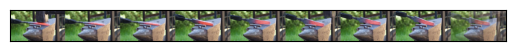

In [13]:
file = "../outputs/tango_video2audio_clip4clip_4/1720425300_tango_video2audio_clip4clip_4_best_steps_300_guidance_3.0_sampleRate_16000_augment/2.wav"
show_mel(file, save_name="ood_4_wav.pdf")
show_video_frames("../data/foleycrafter/2.mp4", save_name="ood_4_video.pdf", frame_rate=2)

/tmp/ipykernel_2189924/99652230.py:56: FutureWarning: Pass sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  ori_wav = librosa.load(audio_file, sr)[0]


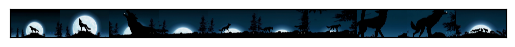

In [16]:
file = "../outputs/tango_video2audio_clip4clip_4/1718173660_tango_video2audio_clip4clip_4_best_steps_300_guidance_3.0_sampleRate_16000_augment/wolf_howling_at_the_moon.wav"
show_mel(file, save_name="ood_5_wav.pdf")
show_video_frames("../data/sora_cut_2/wolf_howling_at_the_moon.mp4", save_name="ood_5_video.pdf", frame_rate=0.2)

/tmp/ipykernel_2189924/99652230.py:56: FutureWarning: Pass sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  ori_wav = librosa.load(audio_file, sr)[0]


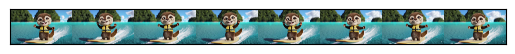

In [17]:
file = "../outputs/tango_video2audio_clip4clip_4/1718173660_tango_video2audio_clip4clip_4_best_steps_300_guidance_3.0_sampleRate_16000_augment/otter_surfboard.wav"
show_mel(file, save_name="ood_6_wav.pdf")
show_video_frames("../data/sora_cut_2/otter_surfboard.mp4", save_name="ood_6_video.pdf", frame_rate=0.4)